<a href="https://colab.research.google.com/github/ljy9969/Study/blob/master/22-04-15%20Deep%20Learning_CNN%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Raw Data Loading

df = pd.read_csv('/content/drive/MyDrive/Colab 멀캠 이지연/mnist/train.csv')

# Data Preprocessing : 결측치, 이상치, 정규화, feature engineering

# Data Split
train_x_data, test_x_data, train_t_data, test_t_data = \
train_test_split(df.drop('label', axis=1, inplace=False),
                 df['label'],
                 test_size=0.3,
                 random_state=1,
                 stratify=df['label'])

# x_data 정규화
scaler = MinMaxScaler()
scaler.fit(train_x_data)
norm_train_x_data = scaler.transform(train_x_data)
norm_test_x_data = scaler.transform(test_x_data)

# t_data One-Hot Encoding 진행 필요 없음

In [ ]:
# Keras 구현

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), # filter 개수, kernel_size=3
                 activation='relu',
                 input_shape=(28,28,1), # (이미지 개수, 이미지 height, 이미지 width, Channel)
                 padding='valid',
                 strides=(1,1))) # strides=1

model.add(MaxPooling2D(pool_size=(2,2))) # strides는 알아서 ksize와 동일하게 잡음. 1/2

model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu',
                 padding='valid',
                 strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu',
                 padding='valid',
                 strides=(1,1))) # (None, 3, 3, 64)

model.add(Flatten()) # 이미지 개수를 제외한 output(3차원)을 1차원으로 펴줌
model.add(Dropout(rate=0.5))
model.add(Dense(units=256, # hidden layer
                activation='relu'))

model.add(Dense(units=10,
                activation='softmax'))

print(model.summary()) # Model 명세

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
# model 실행 옵션
model.compile(optimizer=Adam(learning_rate=1e-3), # 어떤 optimizer를 사용하느냐에 따라 learning rate가 달라짐(알고리즘이 다르기 때문)
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model 학습

# t_data의 일부를 valid_data로 활용해서, 학습이 진행될 때(epoch)마다 평가를 함께 진행
history = model.fit(norm_train_x_data.reshape(-1,28,28,1),
                    train_t_data,
                    epochs=200,
                    batch_size=100,
                    verbose=0,
                    validation_split=0.3)

<class 'keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


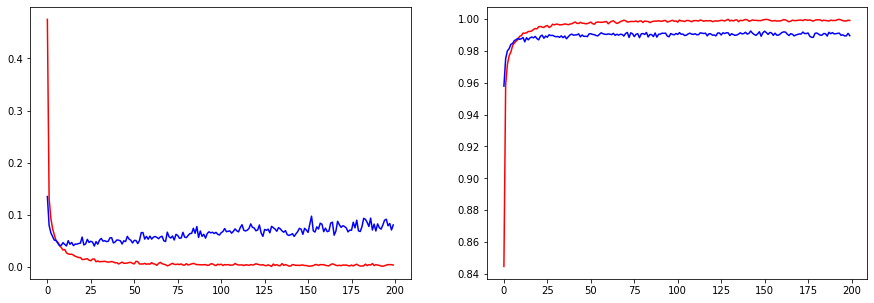

In [ ]:
# print(type(history)) # <class 'keras.callbacks.History'>
# print(history.history.keys()) # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

figure = plt.figure(figsize=(15, 5))

ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

In [ ]:
# 세션 튕겨도 재학습할 필요 없게 학습된 모델 저장(모델의 구조 + 계산된 weights, bias) 확장자는 h5(HDF5) 형식
model.save('/content/drive/MyDrive/Colab 멀캠 이지연/mnist_model_save/my_mnist_model.h5')

In [ ]:
# Evaluation
model.evaluate(norm_test_x_data.reshape(-1,28,28,1), test_t_data) # loss: 0.1032 - accuracy: 0.9900

394/394 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.9900


[0.10324013233184814, 0.9900000095367432]

In [ ]:
# 모델 생성, 학습 없이 저장된 모델을 불러와서 평가
from tensorflow.keras.models import load_model

new_model = load_model('/content/drive/MyDrive/Colab 멀캠 이지연/mnist_model_save/my_mnist_model.h5')
new_model.evaluate(norm_test_x_data.reshape(-1,28,28,1), test_t_data) # loss: 0.1032 - accuracy: 0.9900

394/394 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.9900


[0.10324013233184814, 0.9900000095367432]

In [ ]:
# model 학습(ckpt, early stopping, callback 포함)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Check Point 설정
checkpoint_path = '/content/drive/MyDrive/Colab 멀캠 이지연/mnist_model_save/cp-{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              period=5, # 5 epoch마다 저장
                              verbose=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.001,
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)

history = model.fit(norm_train_x_data.reshape(-1,28,28,1),
                    train_t_data,
                    epochs=50,
                    batch_size=100,
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[cp_callback, es])

Epoch 1/50
206/206 [==============================] - 1s 7ms/step - loss: 8.8413e-04 - accuracy: 0.9996 - val_loss: 0.0843 - val_accuracy: 0.9895
Epoch 2/50
206/206 [==============================] - 1s 5ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0796 - val_accuracy: 0.9912
Epoch 3/50
206/206 [==============================] - 1s 5ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0798 - val_accuracy: 0.9906
Epoch 4/50
206/206 [==============================] - 1s 5ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0887 - val_accuracy: 0.9891
Epoch 5/50
201/206 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 5: saving model to /content/drive/MyDrive/Colab 멀캠 이지연/mnist_model_save/cp-0005.ckpt
206/206 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0780 - val_accuracy: 0.9900
Epoch 6/50
206/206 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9989 - 